## Problema de negocio

Nuestro cliente pertenece al sector retail y necesita un modelo de estimación de demanda para su comercio. La
disponibilidad de los productos es fundamental para ofrecer un excelente servicio al cliente, lo que
implica considerar dos factores críticos: evitar la falta de stock y no excederse en el
abastecimiento de unidades.

## Objetivo

Crear una solición analítica que permita planear la frecuencia y el volumen de las compras necesarias para garantizar la disponibilidad de los productos requeridos sin incurrir en la rotura de stock o en el exceso de aprovisionamiento.

## Objetivo técnico

Crear el mejor modelo de estimación de unidades vendidas para cada
uno de los artículos y para cada uno de los días del año.

Posibles abordajes
- K Means for time series

In [1]:
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
import os

os.chdir("c:\\Users\\HARRY\\Documents\\retail-consulting")

In [127]:
catalogo = pd.read_csv("data/01_raw/catalogo_productos.csv")
demanda = pd.read_csv("data/01_raw/demanda.csv")

## Detección

Información de ventas y atributos de producto entre 01/01/2022 y 30/11/2022.

**Catálogo**

Características de los productos

● Id_producto: número identificador del artículo.

● Categoría: Corresponde a la categoría del artículo

● Sub_categoria: Toma valores de sub categorías del campo categoría

● Tamaño: toma los siguientes valores (pequeño, mediano, grande)

● Premium: Variable dummy. 0 no es premium y 1 es premium

● Marca_exclusiva: Variable dummy. 0 no es exclusiva y 1 es exclusiva

● Estacional: variable dummy que identifica si el producto tiene estacionalidad. 0 no es estacional y 1 es estacional

● Nit_proveedor: código de identificación del proveedor

● date: momento del tiempo en el que se produce el evento.

**Demanda**

Información de la demanda por producto desde el 01/01/2020 hasta el 30/11/2022.

● Id_producto: número identificador del artículo.

● demanda: variable a predecir. Nos indica las unidades vendidas para cada día y cada artículo.

In [3]:
catalogo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id_producto      135 non-null    int64  
 1   categoria        135 non-null    object 
 2   subcategoria     103 non-null    object 
 3   tamaño           132 non-null    object 
 4   premium          130 non-null    float64
 5   marca_exclusiva  135 non-null    int64  
 6   estacional       135 non-null    int64  
 7   nit_proveedor    134 non-null    float64
dtypes: float64(2), int64(3), object(3)
memory usage: 8.6+ KB


In [4]:
demanda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126460 entries, 0 to 126459
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   date         126460 non-null  object
 1   id_producto  126460 non-null  int64 
 2   demanda      126460 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.9+ MB


# Análisis exploratorio

In [83]:
catalogo.isnull().sum()

id_producto         0
categoria           0
subcategoria       32
tamaño              3
premium             5
marca_exclusiva     0
estacional          0
nit_proveedor       1
dtype: int64

In [84]:
catalogo.duplicated().sum()

0

## Catálogo



In [93]:
catalogo.columns

Index(['id_producto', 'categoria', 'subcategoria', 'tamaño', 'premium',
       'marca_exclusiva', 'estacional', 'nit_proveedor'],
      dtype='object')

In [94]:
# Casteo de columnas
for column in catalogo.columns:
    catalogo[column] = catalogo[column].astype("category")

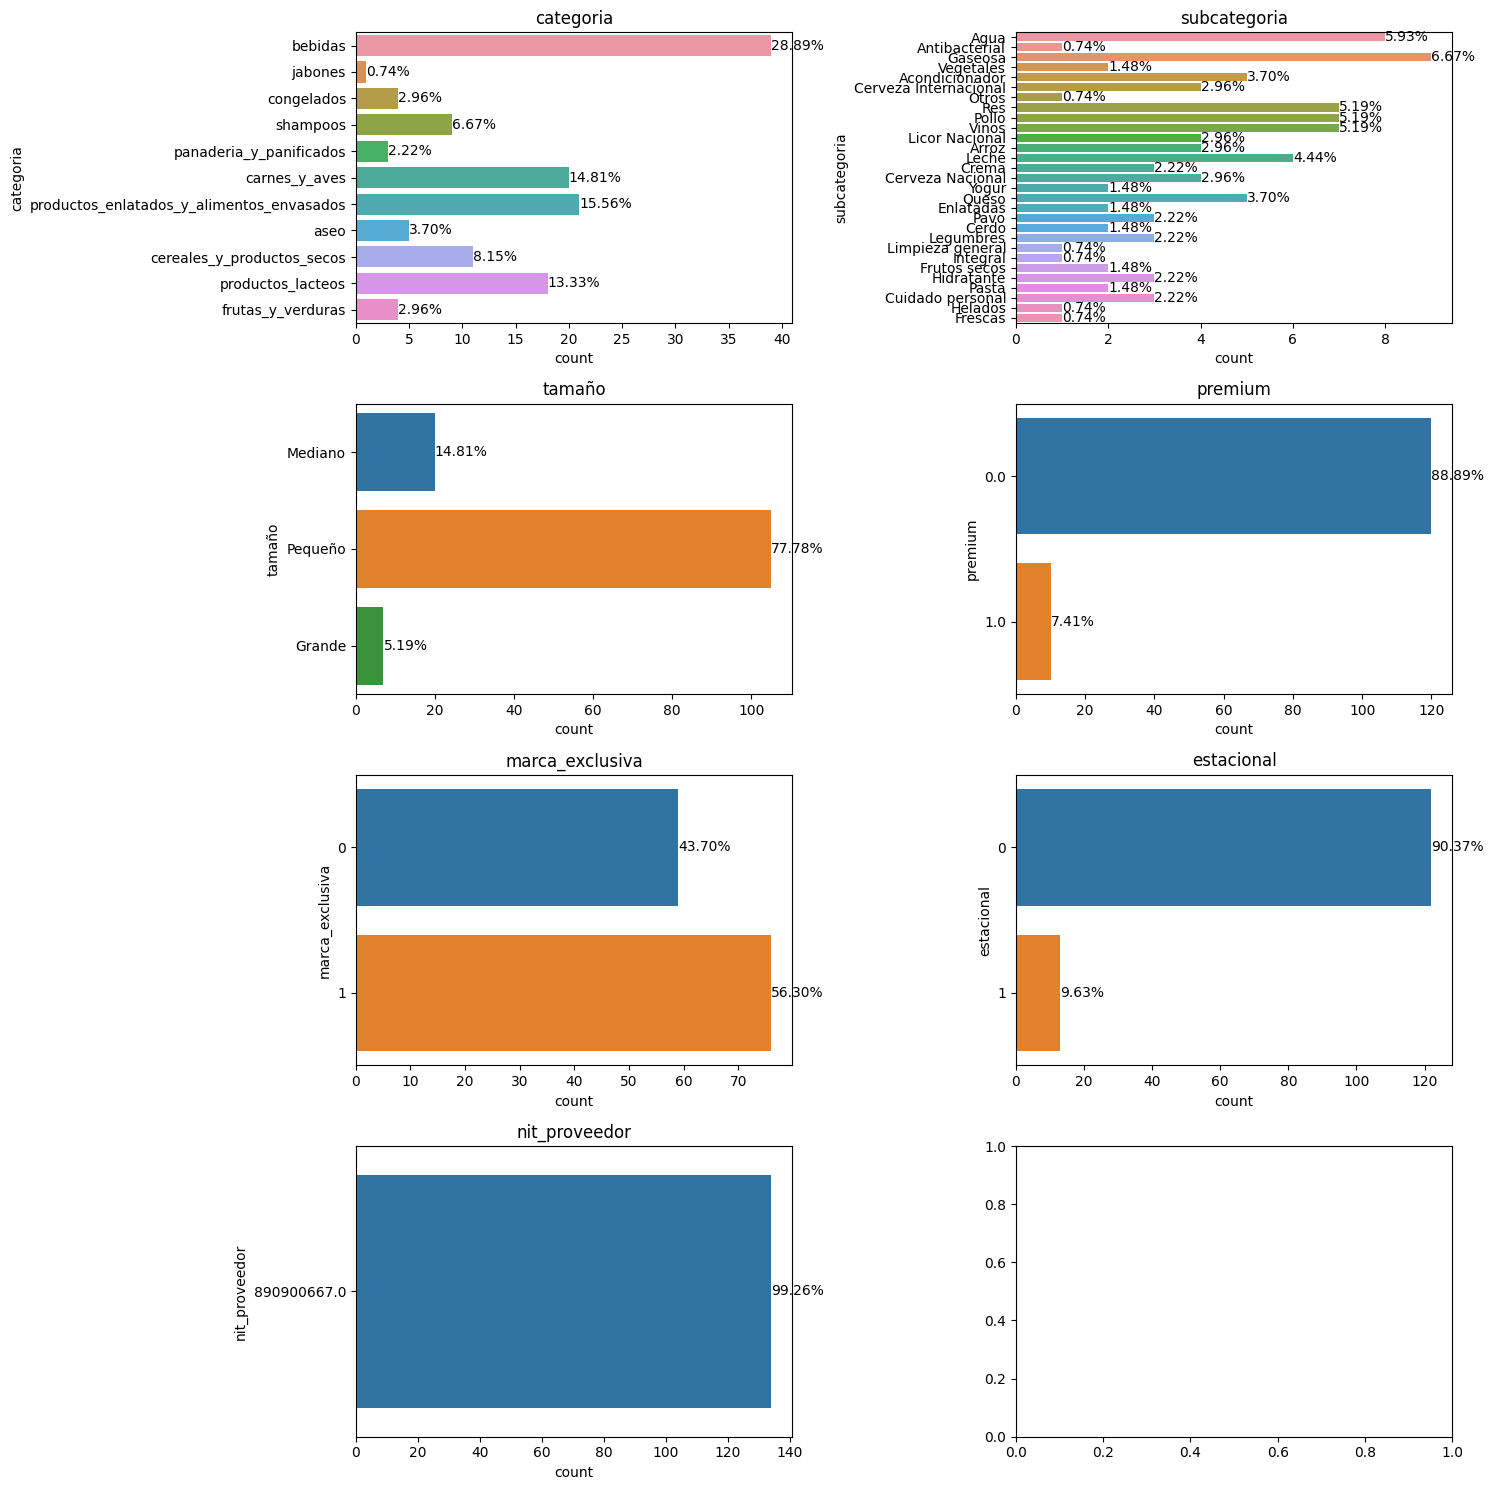

In [128]:
# Definir nombres de columnas
variables = catalogo.columns[1:]

# Calcula el número de subplots basado en el número de columnas
num_subplots = len(variables)

# Define el número de filas y columnas para el diseño de subplots
num_filas = 4  # Ajustable
num_columnas = (num_subplots + num_filas - 1) // num_filas
total = len(catalogo)

# Crea una figura y subplots según el número de columnas
fig, axis = plt.subplots(num_filas, num_columnas, figsize=(15, 15))

# Itera sobre las columnas y crea un gráfico en cada subplot
for i, columna in enumerate(variables):
    fila_actual = i // num_columnas
    columna_actual = i % num_columnas

    ax = sns.countplot(data=catalogo, y=columna, ax=axis[fila_actual, columna_actual])

    # Agrega etiquetas de porcentaje a las barras
    for p in ax.patches:
        width = p.get_width()
        ax.annotate(
            f"{width / total:.2%}",
            (width, p.get_y() + p.get_height() / 2.0),
            ha="left",
            va="center",
        )

    # Agrega el nombre de la variable como titulo de cada gráfica
    axis[fila_actual, columna_actual].set_title(columna)

# Ajusta el espaciado entre subplots para que no se superpongan
plt.tight_layout()

# Muestra los subplots
plt.show()

La variable categoría toma 11 valores diferentes, todos los productos tienen una categoría asignada. Bebidas tiene la mayor participación con 39 productos en esta categoría. Existen 29 valores para subcategoría, hay 32 productos que no tienen una subcategoría asignada. La subcategoría más popular es  

In [133]:
catalogo.groupby('categoria')['subcategoria'].nunique()

categoria
aseo                                         2
bebidas                                      6
carnes_y_aves                                4
cereales_y_productos_secos                   4
congelados                                   2
frutas_y_verduras                            2
jabones                                      1
panaderia_y_panificados                      2
productos_enlatados_y_alimentos_envasados    0
productos_lacteos                            4
shampoos                                     2
Name: subcategoria, dtype: int64

In [175]:
order = [i[1] for i in catalogo.groupby('categoria')['subcategoria'].value_counts().index]
order_categ = [i[0] for i in catalogo.groupby('categoria')['subcategoria'].value_counts().index]

lista_simplificada = []
for elemento in order_categ:
    if elemento not in lista_simplificada:
        lista_simplificada.append(elemento)

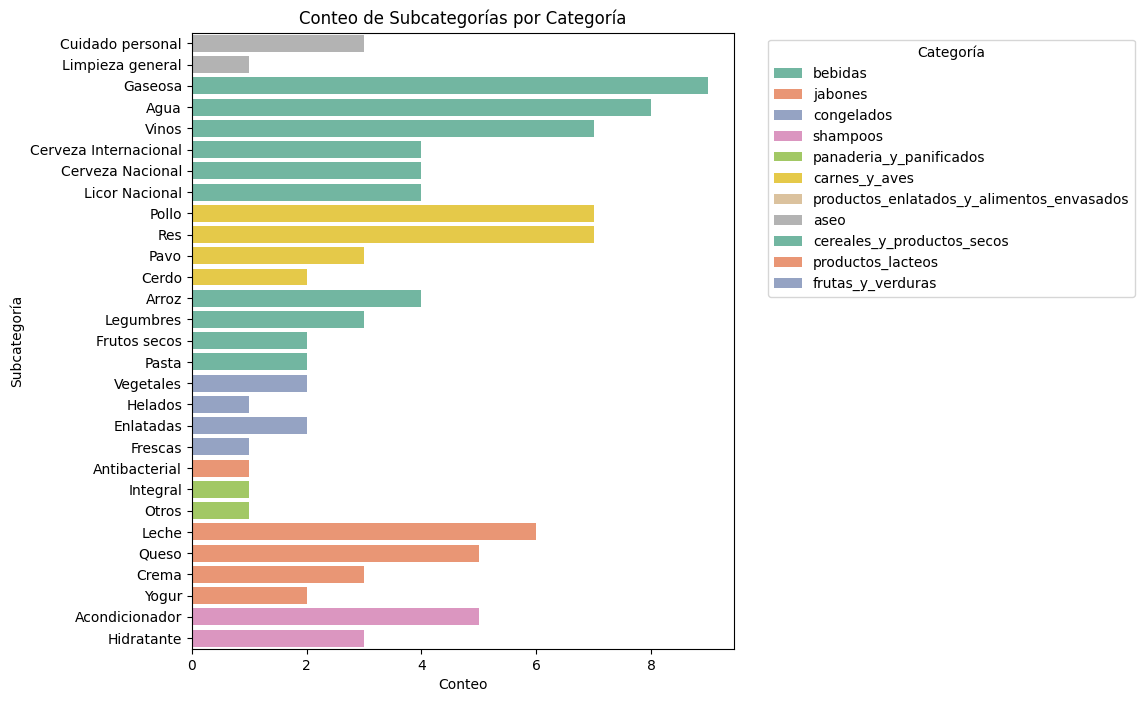

In [174]:
import seaborn as sns
import matplotlib.pyplot as plt

# Supongamos que tienes un DataFrame llamado 'catalogo' con las columnas 'categoria' y 'subcategoria'

# Utiliza Seaborn para contar y visualizar los datos
plt.figure(figsize=(7, 8))
sns.countplot(y='subcategoria', hue='categoria', data=catalogo, palette='Set2', dodge=False, order = order)

# Ajusta la estética del gráfico
plt.xlabel('Conteo')
plt.ylabel('Subcategoría')
plt.title('Conteo de Subcategorías por Categoría')

# Coloca la leyenda fuera del gráfico
plt.legend(title='Categoría', bbox_to_anchor=(1.05, 1), loc='upper left',)

# Muestra el gráfico
plt.show()


## Demanda

In [5]:
demanda.isnull().sum()

date           0
id_producto    0
demanda        0
dtype: int64

In [179]:
demanda.duplicated().sum()

0

In [6]:
demanda_pivot = demanda.pivot(
    index="date", columns="id_producto", values="demanda"
).reset_index()

demanda_pivot.head()

id_producto,date,1,2,3,4,5,6,7,8,9,...,126,127,128,129,130,131,132,133,134,135
0,2020-01-01,NaN,NaN,869.0,407.0,182.0,91.0,520.0,154.0,721.0,...,415.0,912.0,378.0,1064.0,547.0,179.0,769.0,116.0,884.0,713.0
1,2020-01-02,110.0,503.0,785.0,319.0,183.0,49.0,410.0,117.0,538.0,...,302.0,916.0,312.0,822.0,NaN,150.0,617.0,99.0,699.0,660.0
2,2020-01-03,140.0,481.0,777.0,305.0,174.0,51.0,340.0,NaN,545.0,...,316.0,906.0,NaN,859.0,NaN,139.0,661.0,123.0,757.0,648.0
3,2020-01-04,121.0,603.0,679.0,357.0,NaN,54.0,447.0,136.0,609.0,...,383.0,971.0,317.0,811.0,561.0,143.0,696.0,125.0,795.0,NaN
4,2020-01-05,140.0,598.0,782.0,374.0,NaN,49.0,NaN,126.0,656.0,...,318.0,1006.0,314.0,832.0,577.0,138.0,678.0,120.0,767.0,671.0


In [85]:
demanda_pivot.duplicated().sum()

0

In [87]:
vars_check = (
    (
        demanda_pivot.isnull().sum().sort_values(ascending=False)
        * 100
        / len(demanda_pivot)
    )
    .head(13)
    .index.values
)
(
    demanda_pivot.isnull().sum().sort_values(ascending=False) * 100 / len(demanda_pivot)
).head(13)
# Todos los productos tienen valores nulos
# Hay 13 productos con un comportamiento de nulidad alto y similar

id_producto
33     78.779343
104    78.685446
41     78.591549
4      78.497653
58     78.309859
120    78.309859
15     78.215962
86     78.122066
51     78.028169
100    78.028169
90     77.934272
69     77.840376
118    77.652582
dtype: float64

In [ ]:
# profile = ProfileReport(demanda_pivot, title="Demanda Report")
# profile.to_file("data/08_reporting/demanda_report.html")

# profile = ProfileReport(catalogo, title="Catalogo Report")
# profile.to_file("data/08_reporting/catalogo_report.html")

In [180]:
# Grafico de plotly para las series temporales
fig = px.line(demanda_pivot, x="date", y=vars_check, title="Gráfico de Líneas")

# Puedes personalizar el tamaño del gráfico si lo deseas:
fig.update_layout(autosize=False, width=1200, height=400)

# Mostrar el gráfico
fig.show()

# Estos productos solo se venden entre 1 noviembre y 30 de enero
# Son productos estacionales - deben separarse del resto
# Llenar valores nulos con 0 entre periodos vacíos

In [82]:
catalogo[catalogo["id_producto"].isin(vars_check.astype(int))]
# Los 13 productos con comportamiento extraño son los estacionales. 

,id_producto,categoria,subcategoria,tamaño,premium,marca_exclusiva,estacional,nit_proveedor
3,4,congelados,Vegetales,Pequeño,0.0,1,1,890900667.0
14,15,cereales_y_productos_secos,Arroz,Pequeño,0.0,1,1,890900667.0
32,33,productos_enlatados_y_alimentos_envasados,NaN,Pequeño,0.0,1,1,890900667.0
40,41,cereales_y_productos_secos,Legumbres,Pequeño,0.0,1,1,890900667.0
50,51,productos_lacteos,Crema,Pequeño,0.0,0,1,890900667.0
57,58,bebidas,Vinos,Mediano,0.0,0,1,890900667.0
68,69,bebidas,Gaseosa,Pequeño,0.0,1,1,890900667.0
85,86,bebidas,Cerveza Internacional,NaN,NaN,1,1,890900667.0
89,90,bebidas,Vinos,Pequeño,0.0,1,1,890900667.0
99,100,carnes_y_aves,Pollo,Grande,0.0,0,1,890900667.0


In [75]:
catalogo["estacional"].value_counts(dropna=False)

0    122
1     13
Name: estacional, dtype: int64

Procesamiento de series de tiempo

- Imputación
- Descomposición de etacionalidad

Estacional vs no estacional

¿Cuál es la estacionalidad de las ventas?, ¿la estacionalidad cambia dependiendo de la
categoría del producto?. Por favor estime la estacionalidad semanal, mensual y anual.
● ¿Cúal fué el impacto de la apertura del competidor? Por favor cuantifique el impacto
● ¿Las ventas tienen una tendencia creciente o decreciente? Excluya el impacto de la
apertura del competidor del análisis.